In [1]:
%load_ext autoreload
%autoreload 2

from imports import *
from dynamics import *
from model import *

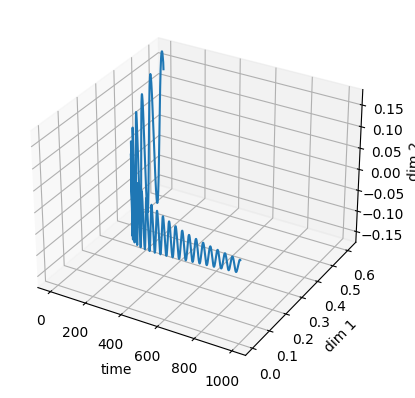

In [2]:
data = dampened_oscillator(m=1.0, c=np.array([100.0, 0.1]), k=np.array([10.0, 10.0]))

plot_3d(data.cpu().numpy())

In [7]:
def loss_fn(model, batch, num_negative_samples):
    margin = 2
    beta = 1

    '''
    positive term loss
    '''
    # E_x_tp1_positive - E_x_t
    min_difference = model(batch[1:, :]) - model(batch[:-1, :])

    positive_loss = torch.mean(torch.maximum(torch.zeros_like(min_difference).cuda(), margin + (min_difference))**2)

    '''
    negative samples: previous `num_negative_samples` in the trajectory given current x_t (i.e. x_{t - num_negative_samples} ... x_{t-1})
    '''
    negative_loss = []

    for i in range(batch.shape[0]-1):
        num_samples = min(i, num_negative_samples)

        if num_samples:
            # E_x_tp1_negative - E_x_t
            max_difference = model(batch[np.random.choice(i, size=(num_samples,), replace=False), :]) - model(batch[i, :].unsqueeze(0)).repeat(num_samples)
            
            '''
            hinge loss with margin
            '''
            loss = torch.sum(
                torch.maximum(torch.zeros(max_difference.shape[0]).cuda(), margin - max_difference)**2
            )

            '''
            Gibbs partition function based loss
            '''
            # loss = 1/beta * torch.log(torch.sum(torch.exp(-beta * max_difference)))

            '''
            negative exponential loss
            '''
            # loss = torch.sum(torch.exp(-max_difference))

            negative_loss.append(loss)

    return positive_loss + sum(negative_loss)/len(negative_loss)


def plot_energy_along_trajectory(model, trajectory):
    with torch.no_grad():
        E_x_t = []

        for x_t in trajectory:
            E_x_t.append(model(x_t.unsqueeze(0)).squeeze().detach().cpu().item())

    plt.plot(E_x_t)
    plt.title("energy along trajectory")

    plt.show()


def plot_energy_landscape(model):
    X = torch.linspace(-10, 10, steps=500)
    Y = torch.linspace(-10, 10, steps=500)

    energy_manifold = model(torch.cartesian_prod(X, Y).cuda()).reshape(X.shape[0], Y.shape[0]).detach().cpu().numpy()

    X, Y = np.meshgrid(X.numpy(), Y.numpy())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    surface = ax.plot_surface(X, Y, energy_manifold, cmap='viridis', edgecolor='k', linewidth=0.5, facecolor=(1,1,1,0.2))

    fig.colorbar(surface, pad=0.1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$energy$')
    ax.set_title('energy landscape')
    
    plt.show()


def epoch(iterations, model, optimizer, data, bs, num_negative_samples):
    losses = []

    for i in range(iterations):
        batch = generate_batch(data, bs=bs)

        optimizer.zero_grad()

        loss = loss_fn(model, batch, num_negative_samples=num_negative_samples)

        loss.backward()

        optimizer.step()

        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

  2%|▏         | 1/50 [00:01<01:11,  1.46s/it]

76.19608001708984


  4%|▍         | 2/50 [00:02<01:10,  1.46s/it]

76.09327087402343


  6%|▌         | 3/50 [00:04<01:08,  1.46s/it]

75.81131973266602


  8%|▊         | 4/50 [00:05<01:07,  1.46s/it]

74.98943176269532


 10%|█         | 5/50 [00:07<01:05,  1.46s/it]

73.61136016845703


 12%|█▏        | 6/50 [00:08<01:04,  1.46s/it]

71.73993644714355


 14%|█▍        | 7/50 [00:10<01:02,  1.46s/it]

62.24372329711914


 16%|█▌        | 8/50 [00:11<01:01,  1.46s/it]

49.33818416595459


 18%|█▊        | 9/50 [00:13<00:59,  1.46s/it]

32.10242118835449


 20%|██        | 10/50 [00:14<00:59,  1.48s/it]

28.758214139938353


 22%|██▏       | 11/50 [00:16<00:57,  1.47s/it]

17.79221341609955


 24%|██▍       | 12/50 [00:17<00:55,  1.46s/it]

16.300480657815932


 26%|██▌       | 13/50 [00:18<00:53,  1.46s/it]

15.769706058502198


 28%|██▊       | 14/50 [00:20<00:52,  1.46s/it]

9.613900423422455


 30%|███       | 15/50 [00:21<00:50,  1.45s/it]

12.133472383022308


 32%|███▏      | 16/50 [00:23<00:49,  1.45s/it]

2.9378541321260854


 34%|███▍      | 17/50 [00:24<00:47,  1.45s/it]

5.6867264524102215


 36%|███▌      | 18/50 [00:26<00:46,  1.45s/it]

3.284513905644417


 38%|███▊      | 19/50 [00:27<00:44,  1.45s/it]

5.73541864163708


 40%|████      | 20/50 [00:29<00:43,  1.45s/it]

3.532345747947693


 42%|████▏     | 21/50 [00:30<00:41,  1.45s/it]

1.763317060470581


 44%|████▍     | 22/50 [00:31<00:40,  1.44s/it]

3.4386142450821353


 46%|████▌     | 23/50 [00:33<00:39,  1.45s/it]

2.926267515635118


 48%|████▊     | 24/50 [00:34<00:37,  1.45s/it]

2.1768374037696048


 50%|█████     | 25/50 [00:36<00:36,  1.45s/it]

1.7383678361773491


 52%|█████▏    | 26/50 [00:37<00:34,  1.45s/it]

2.8872617209795863


 54%|█████▍    | 27/50 [00:39<00:33,  1.45s/it]

1.3921702563762666


 56%|█████▌    | 28/50 [00:40<00:31,  1.45s/it]

0.8919330148568122


 58%|█████▊    | 29/50 [00:42<00:30,  1.45s/it]

2.0133145570755007


 60%|██████    | 30/50 [00:43<00:29,  1.45s/it]

1.7792227054014802


 62%|██████▏   | 31/50 [00:45<00:27,  1.45s/it]

1.152273453772068


 64%|██████▍   | 32/50 [00:46<00:26,  1.45s/it]

2.523903600871563


 66%|██████▌   | 33/50 [00:47<00:24,  1.45s/it]

2.4059576678148007


 68%|██████▊   | 34/50 [00:49<00:23,  1.45s/it]

1.2441543743014336


 70%|███████   | 35/50 [00:50<00:21,  1.46s/it]

0.719078896565145


 72%|███████▏  | 36/50 [00:52<00:20,  1.45s/it]

0.11045116186141968


 74%|███████▍  | 37/50 [00:53<00:18,  1.45s/it]

0.7391819596290589


 76%|███████▌  | 38/50 [00:55<00:17,  1.44s/it]

0.3312303341925144


 78%|███████▊  | 39/50 [00:56<00:16,  1.46s/it]

0.6991589916404337


 80%|████████  | 40/50 [00:58<00:14,  1.46s/it]

0.2862849092995276


 82%|████████▏ | 41/50 [00:59<00:13,  1.45s/it]

1.1296290755271912


 84%|████████▍ | 42/50 [01:01<00:11,  1.45s/it]

0.2508225976256654


 86%|████████▌ | 43/50 [01:02<00:10,  1.45s/it]

0.861509558558464


 88%|████████▊ | 44/50 [01:03<00:08,  1.45s/it]

0.3655626816675067


 90%|█████████ | 45/50 [01:05<00:07,  1.46s/it]

0.6259305325918831


 92%|█████████▏| 46/50 [01:06<00:05,  1.46s/it]

0.9136515915393829


 94%|█████████▍| 47/50 [01:08<00:04,  1.46s/it]

0.2745308604091406


 96%|█████████▌| 48/50 [01:09<00:02,  1.47s/it]

0.3096826016902924


 98%|█████████▊| 49/50 [01:11<00:01,  1.47s/it]

0.31477939784526826


100%|██████████| 50/50 [01:12<00:00,  1.45s/it]

0.541803190857172


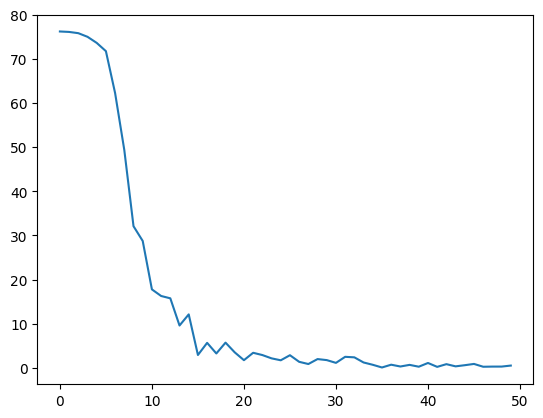

In [8]:
model = EBM(2).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

losses = []

for e in tqdm(range(50)):
    loss = epoch(iterations=10, model=model, optimizer=optimizer, data=data, bs=100, num_negative_samples=20)
    losses.append(loss)
    print(loss)

plt.plot(losses)

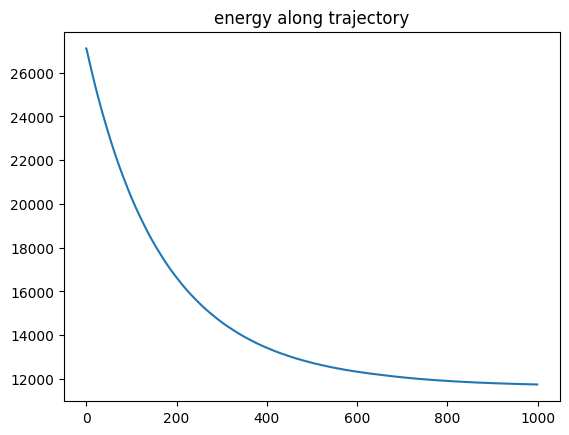

In [9]:
plot_energy_along_trajectory(model, data)

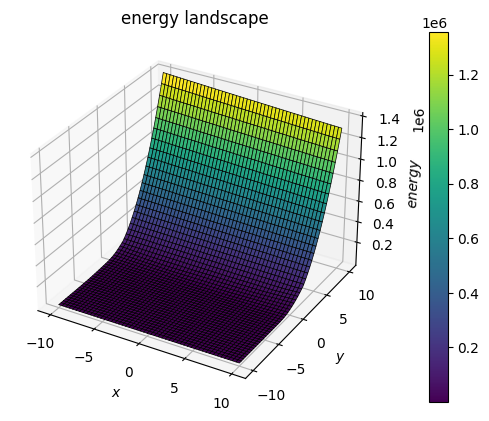

In [10]:
plot_energy_landscape(model)